<a href="https://colab.research.google.com/github/rkudulis/Deep-Learning-Notebooks/blob/main/Fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion Product Images Dataset

The growing e-commerce industry presents us with a large dataset waiting to be scraped and researched upon. In addition to professionally shot high resolution product images, we also have multiple label attributes describing the product which was manually entered while cataloging. To add to this, we also have descriptive text that comments on the product characteristics.

In [ ]:
import torch
from torch import nn
from torchvision import transforms, utils
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import re


In [ ]:
! cp /content/drive/MyDrive/fashion-dataset.zip /content/ -v
!unzip fashion-dataset.zip


'/content/drive/MyDrive/fashion-dataset.zip' -> '/content/fashion-dataset.zip'


In [ ]:
IMAGES_PATH = "/content/fashion-dataset/images"
STYLES_PATH = "/content/fashion-dataset/styles"
STYLES_FILE_PATH = "/content/fashion-dataset/styles.csv"
IMAGES_FILE_PATH = "/content/fashion-dataset/images.csv"

In [137]:
styles_df = pd.read_csv(STYLES_FILE_PATH, index_col=False, error_bad_lines=False)
print(styles_df.shape)
styles_df.head()

(44424, 10)


b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
styles_df.masterCategory = styles_df.masterCategory.astype('category').cat.codes

In [ ]:
images = os.listdir("/content/fashion-dataset/images")
len(images)

44441

In [ ]:
images_list = [re.findall(r"\d+", x)[0] for x in images]
images_list = [int(x) for x in images_list]
len(images_list)

44441

In [ ]:
styles_df = styles_df[styles_df.id.isin(images_list)]
styles_df.shape

(44419, 10)

In [ ]:
train_df, valid_df = torch.utils.data.random_split(styles_df, [30_000, 14_419], generator=torch.Generator().manual_seed(42))

In [ ]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transforms=None):
        self.dataset = dataset
        self.indices = indices
        self.transforms = transforms

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        id = row.id
        label = row.masterCategory
        path = f"/content/images/{id}.jpg"
        image = Image.open(path)
        if self.transforms:
            image = self.transforms(image)
        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(1),
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.Normalize(mean=[.8], std=[.5])
])

In [ ]:
train_dataset = TrainDataset(styles_df, train_df.indices, transforms=transform)
valid_dataset = TrainDataset(styles_df, valid_df, transforms=transform)

torch.Size([1, 256, 256])
2


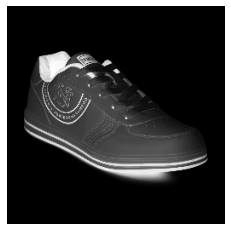

In [ ]:
img, label = train_dataset[155]
print(img.shape)
print(label)
plt.imshow(img.reshape(256,256), cmap='binary')
plt.axis('off');

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 64, shuffle=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 64, shuffle=True, num_workers=4) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
input_size = 256 ** 2
hidden_size = [256, 64]
output_size = 7

model = nn.Sequential(
    nn.Linear(input_size, hidden_size[0]),
    nn.ReLU(),
    nn.Linear(hidden_size[0], hidden_size[1]),
    nn.ReLU(),
    nn.Linear(hidden_size[1], output_size),
    nn.LogSoftmax(dim=1)
)
model

Sequential(
  (0): Linear(in_features=65536, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=7, bias=True)
  (5): LogSoftmax(dim=1)
)

In [ ]:
criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
if torch.cuda.is_available():
    model = model.cuda()
    optimizer = optimizer

In [ ]:
epochs = widgets.IntSlider(2, min=0, max=10)
epochs

IntSlider(value=2, max=10)

In [ ]:
epochs = 1

for e in range(epochs):
    train_running_loss = 0.0
    valid_running_loss = 0.0

    for i in range(16):
        for n, (images, labels) in enumerate(train_dataloader):
            images = images.view(-1, 128*128)
            labels =labels.long()
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item() / 64
            if n * 4 >= 15: break

        with torch.no_grad():
            for n, (images, labels) in enumerate(valid_dataloader):
                images = images.view(-1, 128*128)
                labels =labels.long()
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()

                output = model(images)
                loss = criterion(output, labels)

                valid_running_loss += loss.item() / 64
                if n * 4 >= 15: break

        print('[Epoch: %d, Iteration: %5d] Train Loss: %.5f  |  Valid Loss: %.5f' % (e + 1, i + 1, train_running_loss, valid_running_loss))
        running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

In [ ]:
model.eval()
for images, labels in valid_dataloader:
    images = images.view(-1, 128*128)
    labels =labels.long()
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    output = model(images)
    break

In [ ]:
torch.argmax(output, 1)

tensor([0, 0, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1,
        0, 2, 2, 0, 1, 0, 1, 1, 2, 1, 0, 2, 2, 1, 1, 2, 0, 0, 0, 1, 2, 1, 2, 2,
        2, 0, 1, 0, 2, 1, 1, 0, 2, 1, 2, 0, 1, 5, 0, 1])

In [ ]:
labels

tensor([0, 1, 1, 1, 0, 2, 2, 1, 1, 0, 2, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1,
        0, 2, 2, 0, 1, 0, 1, 1, 2, 1, 0, 2, 2, 1, 1, 2, 0, 0, 0, 1, 2, 1, 2, 2,
        2, 0, 1, 0, 2, 1, 1, 5, 2, 1, 2, 1, 1, 5, 0, 1])

In [ ]:
def imshow(img):
    import numpy as np
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(utils.make_grid(next(iter(train_dataloader))))

RuntimeError: ignored

# fast.ai benchmark

In [133]:
from fastai.vision import *
from sklearn.model_selection import train_test_split

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
path = Path('/content/')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/content')

In [138]:
train_data, valid_data = train_test_split(styles_df)
train_data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
14596,39016,Women,Accessories,Watches,Watches,White,Winter,2016.0,Casual,CASIO ENTICER Women White Dial Analogue Watch ...
11427,17926,Women,Apparel,Bottomwear,Capris,Grey,Fall,2011.0,Casual,Nike Women Casual Grey Capri
38354,15677,Men,Apparel,Bottomwear,Trousers,Beige,Fall,2011.0,Casual,Highlander Men Classic Chinos Beige Trousers
24075,11386,Women,Apparel,Topwear,Sweatshirts,Green,Fall,2011.0,Casual,United Colors Of Benetton Women Light Winter G...
26216,5001,Women,Apparel,Bottomwear,Capris,Blue,Summer,2011.0,Casual,Gini and Jony Girl's Tamira Blue Kidswear


In [151]:
train_data['label'] = train_data.masterCategory + " " + train_data.subCategory
train_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,label
14596,39016,Women,Accessories,Watches,Watches,White,Winter,2016.0,Casual,CASIO ENTICER Women White Dial Analogue Watch ...,Accessories Watches
11427,17926,Women,Apparel,Bottomwear,Capris,Grey,Fall,2011.0,Casual,Nike Women Casual Grey Capri,Apparel Bottomwear
38354,15677,Men,Apparel,Bottomwear,Trousers,Beige,Fall,2011.0,Casual,Highlander Men Classic Chinos Beige Trousers,Apparel Bottomwear
24075,11386,Women,Apparel,Topwear,Sweatshirts,Green,Fall,2011.0,Casual,United Colors Of Benetton Women Light Winter G...,Apparel Topwear
26216,5001,Women,Apparel,Bottomwear,Capris,Blue,Summer,2011.0,Casual,Gini and Jony Girl's Tamira Blue Kidswear,Apparel Bottomwear


In [156]:
?? ImageList.label_from_df

In [2]:
import numpy as np
np.random.seed(42)
src = (ImageList.from_df(df=train_data.sample(3000), path='images', cols='id', suffix=".jpg")
    .split_by_rand_pct(0.2)
    .label_from_df(label_delim=" ", cols='label'))

NameError: ignored

In [158]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

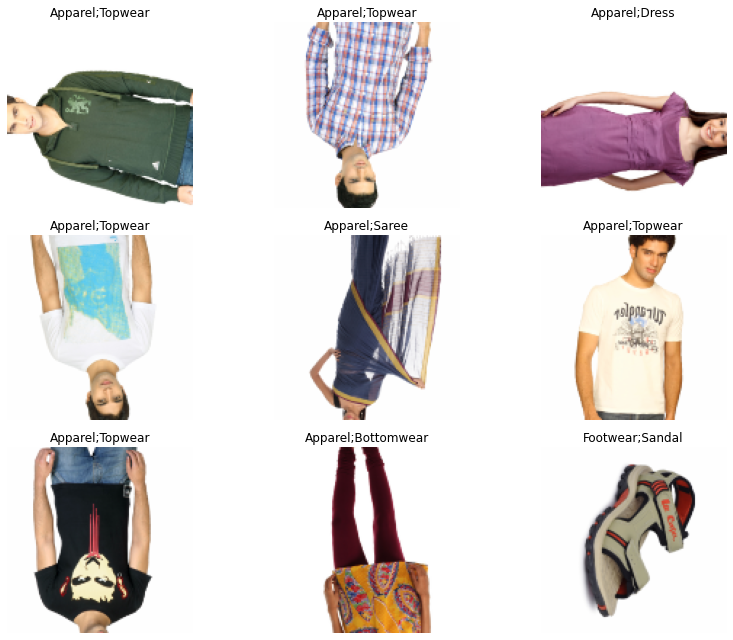

In [159]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")


data.show_batch(rows=3, figsize=(12,9))

In [160]:
arch = models.resnet50

In [161]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [164]:
?? learn.lr_find

In [162]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

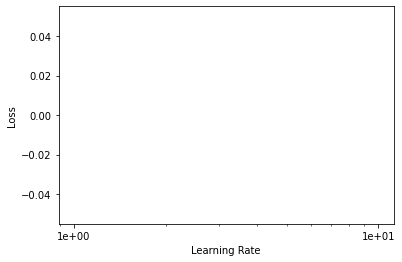

In [163]:
learn.recorder.plot()

In [165]:
lr = 0.01

In [168]:
?? learn.fit_one_cycle

In [170]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


FileNotFoundError: ignored